In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

### DAB Structure and Inference

In [3]:
# import the modules and functions
import torch
from pann_net import PANN, EulerCell_DAB
from pann_utils import evaluate


# define circuit parameters and network variables
n, RL, Lr = 1, 120e-3, 63e-6
Ts = 1/50e3
Tslen = 100
dt = Ts/Tslen

dab_Euler_cell = torch.jit.script(EulerCell_DAB(dt, Lr, RL, n)) # define the Euler cell for DAB
pann_dab = torch.jit.script(PANN(dab_Euler_cell)) # define the PANN for DAB
print(pann_dab)

RecursiveScriptModule(
  original_name=PANN
  (cell): RecursiveScriptModule(original_name=EulerCell_DAB)
)


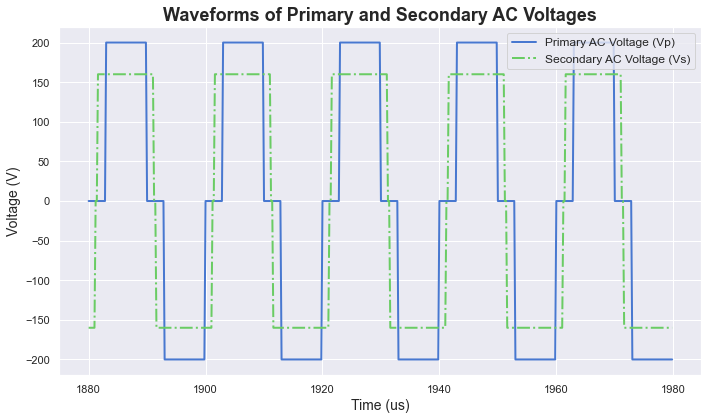

In [4]:
import numpy as np
from pann_utils import create_vpvs, get_inputs


D0, D1, D2 = 0.1, 0.7, 0.95
Vin, Vref = 200, 160
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)




#################################################################################
# plot the ac voltage waveforms (vp and vs)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set(style="darkgrid")  # Use a dark grid background for contrast
# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the waveforms with Seaborn style enhancements
plt.plot(t[-5*Tslen:]*1e6, vp[-5*Tslen:], label='Primary AC Voltage (Vp)', 
         color=sns.color_palette("muted")[0], linestyle='-', linewidth=2)
plt.plot(t[-5*Tslen:]*1e6, vs[-5*Tslen:], label='Secondary AC Voltage (Vs)', 
         color=sns.color_palette("muted")[2], linestyle='-.', linewidth=2)

# Add a title and labels
plt.title('Waveforms of Primary and Secondary AC Voltages', fontsize=18, weight='bold')
plt.xlabel('Time (us)', fontsize=14)
plt.ylabel('Voltage (V)', fontsize=14)

# Add a grid for better readability (already part of Seaborn darkgrid)
plt.grid(True)
# Add a legend to describe the waveforms
plt.legend(loc='upper right', fontsize=12)
# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [5]:
# construct inputs tensor in numpy
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
print(inputs.shape, type(inputs)) # inputs should be of shape (bs x seq_len x inp_dim)
# convert to torch FloatTensor
inputs = torch.FloatTensor(inputs)
print(inputs.shape, type(inputs))


# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states = pann_dab(inputs, state0)
print(states.shape, type(states))


(1, 9900, 2) <class 'numpy.ndarray'>
torch.Size([1, 9900, 2]) <class 'torch.Tensor'>
torch.Size([1, 9900, 1]) <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


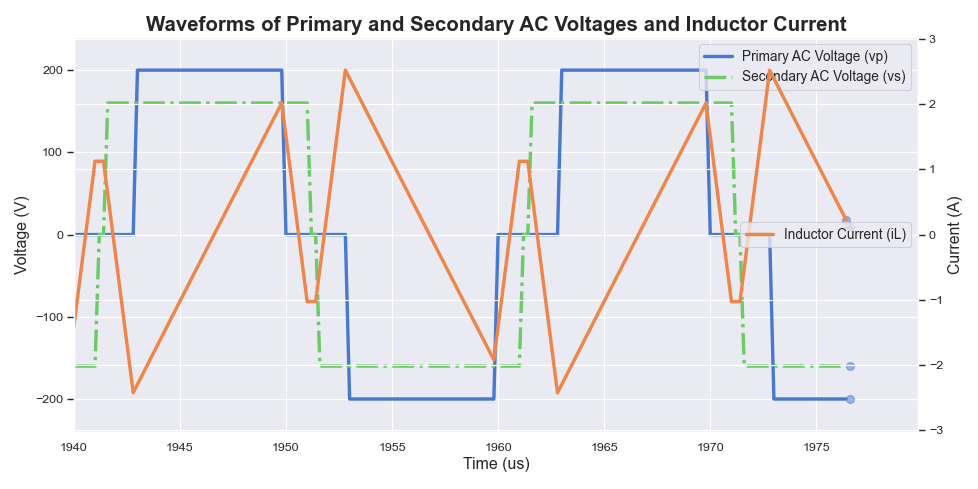

In [6]:
#################################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
# if use google colab
# %matplotlib widget


if len(inputs.shape)==3:
    t = t[-2*Tslen:]*1e6
    inputs = inputs[0, -2*Tslen:]
    states = states[0, -2*Tslen:]
# Example data for vp and vs
# inputs: size (seqlen x inp_dim)
# states: size (seqlen x state_dim)
sns.set(style="darkgrid")  # Use a dark grid background for contrast

t, inputs, states = np.array(t), np.array(inputs), np.array(states)
vp, vs, iL = inputs[:, 0], inputs[:, 1], states[:, 0]
# Create figure and subplots (two subplots: one for vp, one for vs)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax2 = ax1.twinx()

# Set limits for both plots
ax1.set_xlim(t.min(), t.max())
ax1.set_ylim(-inputs.max()*1.2, inputs.max()*1.2)
# ax2.set_xlim(t.min(), t.max())
ax2.set_ylim(-states.max()*1.2, states.max()*1.2)

# Labels and titles
ax1.set_title('Waveforms of Primary and Secondary AC Voltages and Inductor Current', fontsize=18, weight='bold')
# ax2.set_title('Waveforms of Inductor Current', fontsize=18, weight='bold')
ax1.set_xlabel('Time (us)', fontsize=14)
ax1.set_ylabel('Voltage (V)', fontsize=14)
ax2.set_xlabel('Time (us)', fontsize=14)
ax2.set_ylabel('Current (A)', fontsize=14)

# Initialize empty lines for both plots
line1_1, = ax1.plot([], [], lw=3, label='Primary AC Voltage (vp)', 
                    color=sns.color_palette("muted")[0], linestyle='-')
line1_2, = ax1.plot([], [], lw=3, label='Secondary AC Voltage (vs)',
                   color=sns.color_palette("muted")[2], linestyle='-.')
line2_1, = ax2.plot([], [], lw=3, label='Inductor Current (iL)', 
                    color=sns.color_palette("muted")[1], linestyle='-')
dot1_1 = ax1.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                     s=50, color=sns.color_palette("muted")[0], marker="o")
dot1_2 = ax1.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                     s=50, color=sns.color_palette("muted")[0], marker="o")
dot2_1 = ax2.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                     s=50, color=sns.color_palette("muted")[0], marker="o")
dot2_2 = ax2.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                     s=100, color=sns.color_palette("muted")[4], marker="*")

# Add grids and legends
ax1.grid(True)
ax2.grid(True)
ax1.legend(loc='upper right', fontsize=12)
ax2.legend(loc='center right', fontsize=12)

# Initialize the animation
def init():
    line1_1.set_data([], [])
    line1_2.set_data([], [])
    line2_1.set_data([], [])
    dot1_1.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 1
    dot1_2.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 1
    dot2_1.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 2
    dot2_2.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 2
    return line1_1, line1_2, line2_1, dot1_1, dot1_2, dot2_1, dot2_2

# Update the plots
def update(frame):
    line1_1.set_data(t[:frame+1], vp[:frame+1])  # Update vp plot progressively
    line1_2.set_data(t[:frame+1], vs[:frame+1])  # Update vs plot progressively
    line2_1.set_data(t[:frame+1], iL[:frame+1])  # Update iL plot progressively
    dot1_1.set_offsets(np.c_[t[frame+1], vp[frame+1]])
    dot1_2.set_offsets(np.c_[t[frame+1], vs[frame+1]])
    dot2_1.set_offsets(np.c_[t[frame], iL[frame]])
    dot2_2.set_offsets(np.c_[t[frame+1], iL[frame+1]])

    return line1_1, line1_2, line2_1, dot1_1, dot1_2, dot2_1, dot2_2


# Create the animation
ani = FuncAnimation(fig, update, frames=inputs.shape[0]-1, 
                    init_func=init, blit=False, interval=5)

# save as GIF file
# ani.save('DAB-inference.gif', writer='pillow')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
# Display the animation in Jupyter
plt.show()

### DAB Training (Specifications are given in PE-GPT)
* Vin = 200 V, Vo in the range of [160 V, 240 V], n = 1

In [7]:
import pickle
import numpy as np
from pann_train import CustomDataset


# Load the waveforms
# Note: only part of the data is provided
with open("../data/waveforms.pickle", "rb+") as f:
    inputs, states = pickle.load(f)
    
    
train_pct = 0.2
test_pct = 0.4

np.random.seed(888)
idx = np.random.permutation(inputs.shape[0]) # shuffle index
# train-test-val partition of inputs
train_inputs = inputs[idx[:round(train_pct*inputs.shape[0])]]
test_inputs = inputs[idx[round(train_pct*inputs.shape[0]):round((train_pct+test_pct)*inputs.shape[0])]]
val_inputs = inputs[idx[round((train_pct+test_pct)*inputs.shape[0]):]]
# train-test-val partition of states
train_states = states[idx[:round(train_pct*inputs.shape[0])]]
test_states = states[idx[round(train_pct*inputs.shape[0]):round((train_pct+test_pct)*inputs.shape[0])]]
val_states = states[idx[round((train_pct+test_pct)*inputs.shape[0]):]]

print(train_inputs.shape, test_inputs.shape, val_inputs.shape)
print(train_states.shape, test_states.shape, val_states.shape)

(2, 2250, 2) (5, 2250, 2) (5, 2250, 2)
(2, 251, 1) (5, 251, 1) (5, 251, 1)


In [8]:
import torch
from torch.utils.data import DataLoader


# convert numpy arrays to torch tensors
train_inputs = torch.Tensor(train_inputs)
test_inputs = torch.Tensor(test_inputs)
val_inputs = torch.Tensor(val_inputs)
train_states = torch.Tensor(train_states)
test_states = torch.Tensor(test_states)
val_states = torch.Tensor(val_states)

# define DataLoader for the training process
data_loader_train = DataLoader(
    dataset=CustomDataset(train_states[:, :-1], train_inputs[:, 1:],
                          train_states[:, 1:]),
    batch_size=40, shuffle=True, drop_last=False)

In [9]:
import numpy as np
from torch import nn
from pann_train import train
from pann_net import PANN, EulerCell_DAB, WeightClamp
from pann_utils import evaluate


# define the random seed
np.random.seed(888)

# initialize the pann
n, RL, Lr = 1.1, 10e-3, 80e-6 # initial estimation of the circuit parameters
Ts = 1/50e3
Tslen = 250
dt = Ts/Tslen
dab_Euler_cell = torch.jit.script(EulerCell_DAB(dt, Lr, RL, n)) # define the Euler cell for DAB
pann_dab = torch.jit.script(PANN(dab_Euler_cell)) # define the PANN for DAB

# define the optimizer
param_list = ['cell.Lr']
param_list2 = ['cell.n']
param_list3 = ['cell.RL']
params = list(filter(lambda kv: kv[0] in param_list, pann_dab.named_parameters()))
params2 = list(filter(lambda kv: kv[0] in param_list2, pann_dab.named_parameters()))
params3 = list(filter(lambda kv: kv[0] in param_list3, pann_dab.named_parameters()))
# define different learning rates for different circuit parameters
optimizer_pann = torch.optim.Adam([{"params": [param[1] for param in params], "lr":2e-6},
                                   {"params": [param[1] for param in params2], "lr":1e-1},
                                   {"params": [param[1] for param in params3], "lr":5e-1},])

# create a weight clamper to restrict circuit parameter values
clamper = WeightClamp(['cell.Lr', 'cell.RL', 'cell.n'],
                      [(10e-6, 200e-6), (1e-3, 5e0), (0.8, 1.2)]) # clamp the coefficient F

# define the training loss
loss_pann = nn.MSELoss()

test_data = (test_inputs, test_states)
val_data = (val_inputs, val_states)
# start the training of PANN for DAB
best_pann_states, circuit_estimation_history, \
loss_history, val_waveforms = train(pann_dab, clamper, optimizer_pann, data_loader_train, test_data, 
                                    val_data, Tslen, convert_to_mean=True, epoch=75, verbose=True)
circuit_estimation_history, loss_history = np.array(circuit_estimation_history), np.array(loss_history)

Estimations for circuit parameters:  [7.8e-05, 0.001, 1.0]
Epoch 0, Training loss 0.489
New loss is 0.5256872730595725.
---------------------------------------------------------------------------------
Estimations for circuit parameters:  [7.61e-05, 0.041904, 1.0125232]
Epoch 1, Training loss 0.454
New loss is 0.4500925966671535.
---------------------------------------------------------------------------------
Estimations for circuit parameters:  [7.41e-05, 0.1959347, 1.0503244]
Epoch 2, Training loss 0.303
New loss is 0.34984591603279114.
---------------------------------------------------------------------------------
Estimations for circuit parameters:  [7.22e-05, 0.2481129, 1.0703071]
Epoch 3, Training loss 0.188
Estimations for circuit parameters:  [7.05e-05, 0.1658725, 1.0578053]
Epoch 4, Training loss 0.232
New loss is 0.2981349527835846.
---------------------------------------------------------------------------------
Estimations for circuit parameters:  [6.89e-05, 0.0185163, 1

Estimations for circuit parameters:  [6.29e-05, 1.194787, 1.000223]
Epoch 73, Training loss 0.012
Estimations for circuit parameters:  [6.29e-05, 1.1945789, 1.0005281]
Epoch 74, Training loss 0.012


<IPython.core.display.Javascript object>


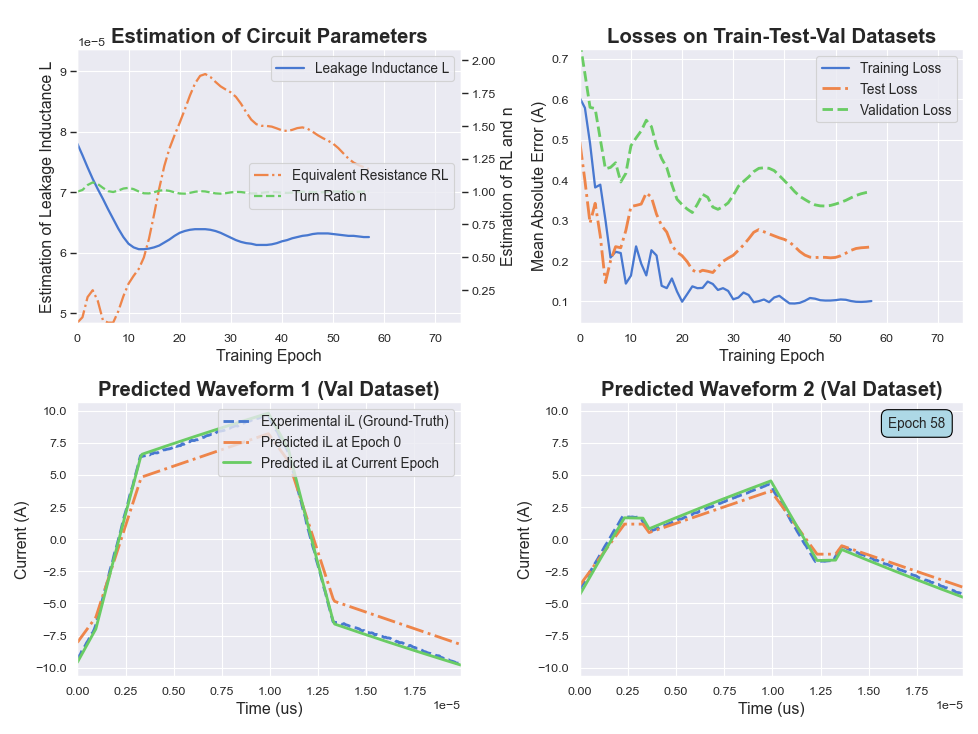

In [10]:
#################################################################################
# Three plots are shown for the training process:
# (1) estimation for circuit parameters
# (2) loss trajectories, all losses are shown
# (3) iL waveform predictions (provide two cases in val set)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
%matplotlib notebook
# if use google colab
# %matplotlib widget


# inputs: size (seqlen x inp_dim)
# states: size (seqlen x state_dim)
sns.set(style="darkgrid")  # Use a dark grid background for contrast

# Create figure and subplots (two subplots: one for vp, one for vs)
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 9))
ax11_2 = ax11.twinx()

# Set limits for both plots
t = np.array([i*dt for i in range(len(val_waveforms[0][0]))])
indices = np.array([i for i in range(len(loss_history))])
ax11.set_xlim(0, len(loss_history))
ax12.set_xlim(0, len(loss_history))
ax21.set_xlim(t.min(), t.max())
ax22.set_xlim(t.min(), t.max())


# Labels and titles
ax11.set_title('Estimation of Circuit Parameters', fontsize=18, weight='bold')
ax12.set_title('Losses on Train-Test-Val Datasets', fontsize=18, weight='bold')
ax21.set_title('Predicted Waveform 1 (Val Dataset)', fontsize=18, weight='bold')
ax22.set_title('Predicted Waveform 2 (Val Dataset)', fontsize=18, weight='bold')
ax11.set_xlabel('Training Epoch', fontsize=14)
ax11.set_ylabel('Estimation of Leakage Inductance L', fontsize=14)
ax11_2.set_ylabel('Estimation of RL and n', fontsize=14)
ax12.set_xlabel('Training Epoch', fontsize=14)
ax12.set_ylabel('Mean Absolute Error (A)', fontsize=14)
ax21.set_xlabel('Time (us)', fontsize=14)
ax21.set_ylabel('Current (A)', fontsize=14)
ax22.set_xlabel('Time (us)', fontsize=14)
ax22.set_ylabel('Current (A)', fontsize=14)
ax11.set_ylim(circuit_estimation_history[:, 0].min()*0.8, circuit_estimation_history[:, 0].max()*1.2)
ax11_2.set_ylim(circuit_estimation_history[:, 1].min()*0.8, circuit_estimation_history[:, 1].max()*1.1)
ax12.set_ylim(loss_history[:, 0].min()*0.5, loss_history[:, 0].max()*1.2)
ax21.set_ylim(-val_states.max()*1.1, val_states.max()*1.1)
ax22.set_ylim(-val_states.max()*1.1, val_states.max()*1.1)


# Initialize empty lines for all plots
# lines for plot 1 - estimation for circuit parameters
line11_1, = ax11.plot([], [], lw=2, label='Leakage Inductance L', 
                    color=sns.color_palette("muted")[0], linestyle='-')
line11_2, = ax11_2.plot([], [], lw=2, label='Equivalent Resistance RL',
                   color=sns.color_palette("muted")[1], linestyle='-.')
line11_3, = ax11_2.plot([], [], lw=2, label='Turn Ratio n',
                   color=sns.color_palette("muted")[2], linestyle='--')
# lines for plot 2 - loss trajectories
line12_1, = ax12.plot([], [], lw=2, label='Training Loss', 
                    color=sns.color_palette("muted")[0], linestyle='-')
line12_2, = ax12.plot([], [], lw=2.5, label='Test Loss',
                   color=sns.color_palette("muted")[1], linestyle='-.')
line12_3, = ax12.plot([], [], lw=2.5, label='Validation Loss',
                   color=sns.color_palette("muted")[2], linestyle='--')
# lines for plot 3 - case study 1 (validation waveforms)
line21_1, = ax21.plot([], [], lw=2.5, label='Experimental iL (Ground-Truth)', 
                    color=sns.color_palette("muted")[0], linestyle='--')
line21_2, = ax21.plot([], [], lw=2.5, label='Predicted iL at Epoch 0', 
                    color=sns.color_palette("muted")[1], linestyle='-.')
line21_3, = ax21.plot([], [], lw=2.5, label=f'Predicted iL at Current Epoch', 
                    color=sns.color_palette("muted")[2], linestyle='-')
# lines for plot 4 - case study 2 (validation waveforms)
line22_1, = ax22.plot([], [], lw=2.5, label='Experimental iL (Ground-Truth)', 
                    color=sns.color_palette("muted")[0], linestyle='--')
line22_2, = ax22.plot([], [], lw=2.5, label='Predicted iL at Epoch 0', 
                    color=sns.color_palette("muted")[1], linestyle='-.')
line22_3, = ax22.plot([], [], lw=2.5, label=f'Predicted iL at Current Epoch', 
                    color=sns.color_palette("muted")[2], linestyle='-')
text22 = ax22.text(1.75e-5, 9, "",
                   fontsize=12, va='center', ha='center',
                   bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Add grids and legends
ax11.grid(True)
ax11_2.grid(False)
ax12.grid(True)
ax21.grid(True)
ax22.grid(True)
ax11.legend(loc='upper right', fontsize=12)
ax11_2.legend(loc='center right', fontsize=12)
ax12.legend(loc='upper right', fontsize=12)
ax21.legend(loc='upper right', fontsize=12)
# ax22.legend(loc='upper right', fontsize=12)


# Initialize the animation
def init():
    line11_1.set_data([], [])
    line11_2.set_data([], [])
    line11_3.set_data([], [])
    line12_1.set_data([], [])
    line12_2.set_data([], [])
    line12_3.set_data([], [])
    line21_1.set_data([], [])
    line21_2.set_data([], [])
    line21_3.set_data([], [])
    line22_1.set_data([], [])
    line22_2.set_data([], [])
    line22_3.set_data([], [])
    text22.set_text("")
    
    return line11_1, line11_2, line11_3, line12_1, line12_2, line12_3,\
            line21_1, line21_2, line21_3, line22_1, line22_2, line22_3, text22

# Update the plots
def update(frame):
    line11_1.set_data(indices[:frame], circuit_estimation_history[:frame, 0])  # Update L estimation progressively
    line11_2.set_data(indices[:frame], circuit_estimation_history[:frame, 1])  # Update RL estimation progressively
    line11_3.set_data(indices[:frame], circuit_estimation_history[:frame, 2])  # Update n estimation progressively
    line12_1.set_data(indices[:frame], loss_history[:frame, 0])  # Update training loss progressively
    line12_2.set_data(indices[:frame], loss_history[:frame, 1])  # Update test loss progressively
    line12_3.set_data(indices[:frame], loss_history[:frame, 2])  # Update validation loss progressively
    if frame == 0:
        line21_1.set_data(t, val_states[0, 1:, 0]) # plot once
        line21_2.set_data(t, val_waveforms[0][0, :, 0]) # plot once
    line21_3.set_data(t, val_waveforms[frame][0, :, 0])  # Update predicted iL of Case 1 progressively
    if frame == 0:
        line22_1.set_data(t, val_states[3, 1:, 0]) # plot once
        line22_2.set_data(t, val_waveforms[0][1, :, 0]) # plot once
    line22_3.set_data(t, val_waveforms[frame][1, :, 0])  # Update predicted iL of Case 2 progressively
    text22.set_text(f"Epoch {frame}")
    
    return line11_1, line11_2, line11_3, line12_1, line12_2, line12_3,\
            line21_1, line21_2, line21_3, line22_1, line22_2, line22_3, text22


# Create the animation
ani = FuncAnimation(fig, update, frames=len(loss_history), 
                    init_func=init, blit=False, interval=100)

# save as GIF file
# ani.save('DAB-inference.gif', writer='pillow')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
# Display the animation in Jupyter
plt.show()

In [10]:
# save the dict of the best PANN checkpoint
torch.save(best_pann_states, "model_pann.pth")